# Case Visualisation Metrification

__This notebook deals with visualisation and furthermore, find out a metric which can assertain the effectiveness of a policy just from case data__






In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 10]
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from random import randrange
import pylab
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
from scipy.ndimage import gaussian_filter1d


In [2]:
case_df = pd.read_csv('../dataset/case_1121_cdc.csv',parse_dates=['submission_date'])


In [3]:
target_df = case_df[case_df['state']=='MD']

# Ordering the data according to the date
target_df = target_df.sort_values(by=['submission_date'])

# Creating a list of columns to drop 
columns_to_drop = target_df.columns.to_list()

# Removing important columns from drop list
columns_to_drop.remove('state')
columns_to_drop.remove('new_case')
columns_to_drop.remove('submission_date')

# Dropping columns not rquired 
target_df = target_df.drop(columns_to_drop, axis=1)



# 1. Raw Case Data

### ` looking at only one state first for experimentation`

Its really bad, the reporting is so poor due to mass ingestion of data on some days of the week leading to this bad graph. 

This is because a lot of states mess up the data ingestion and mass upload data on different days , which is why no clear trends can be made from __RAW__ case data.<br/> __refer [01]__ . 
<br/>
> Hence a preinterpolation is heavily required

__BIBLIOGRAPHY [0]__  concurs and lists some issues as to why this happens  

<AxesSubplot:xlabel='submission_date'>

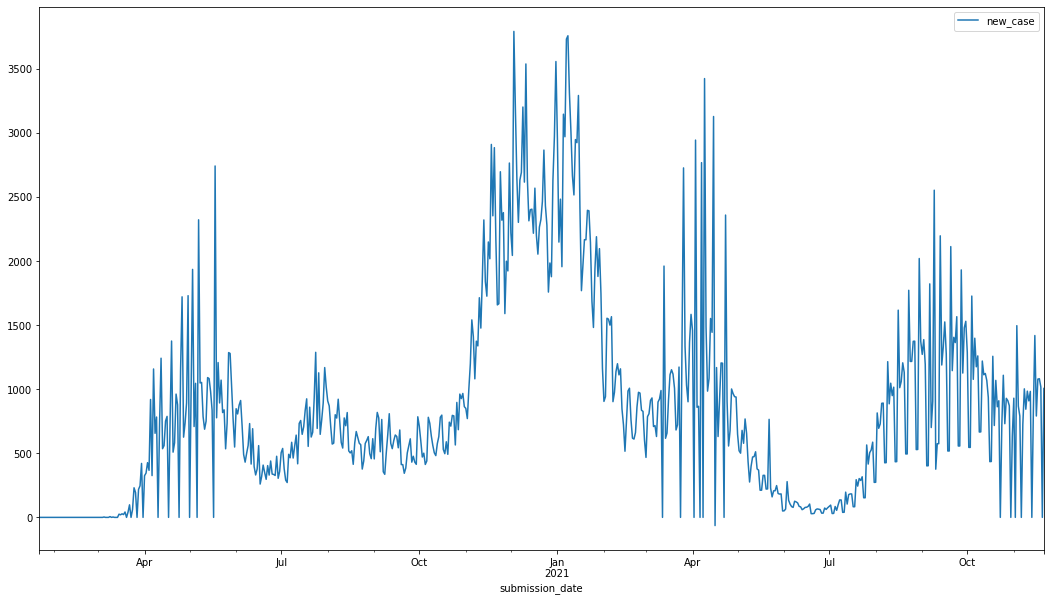

In [4]:
# Plotting Cases wrt. date 
target_df.plot(y='new_case',x='submission_date')

# 1. Trying interpolation


## Moving Average of 15 days 

<AxesSubplot:xlabel='submission_date'>

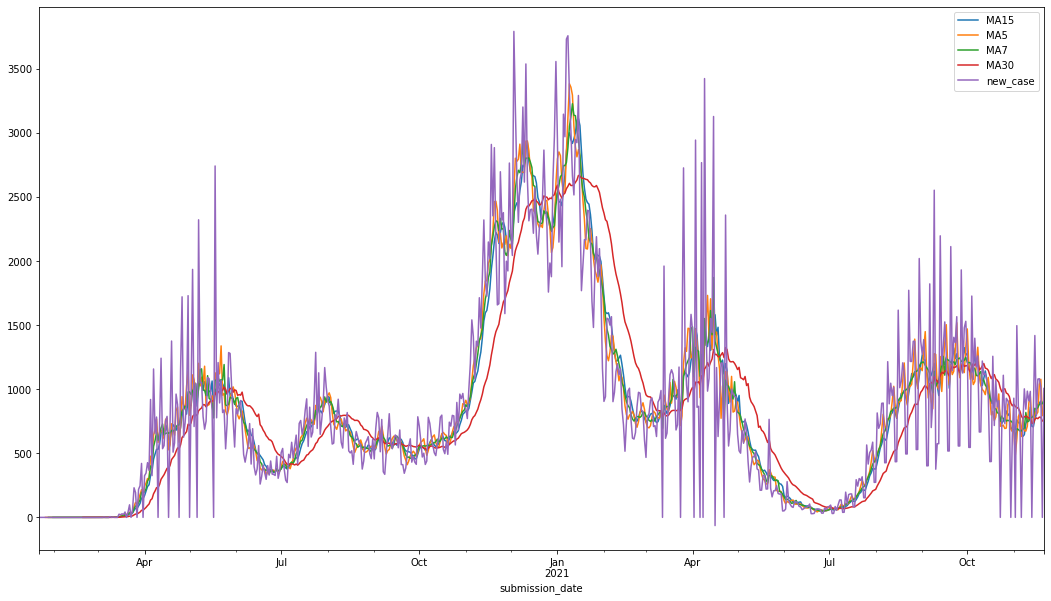

In [5]:
target_df['MA15'] = target_df.loc[:,'new_case'].rolling(window=10).mean()
target_df['MA5'] = target_df.loc[:,'new_case'].rolling(window=5).mean()
target_df['MA7'] = target_df.loc[:,'new_case'].rolling(window=7).mean()
target_df['MA30'] = target_df.loc[:,'new_case'].rolling(window=30).mean()
target_df.plot(y=['MA15','MA5','MA7','MA30','new_case'],x='submission_date')

## Filtering Maybe ? 

<AxesSubplot:xlabel='submission_date'>

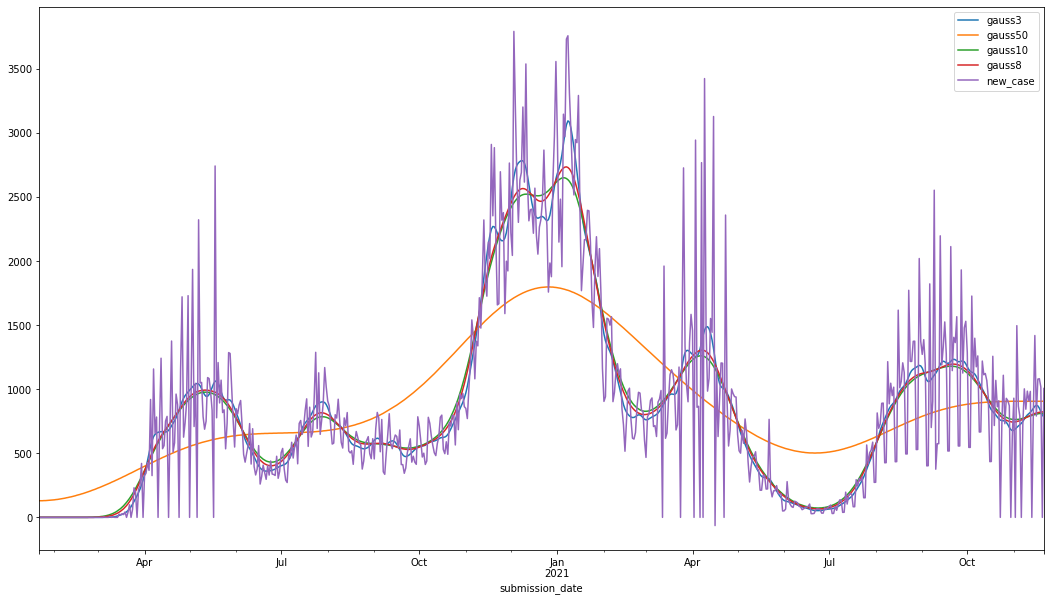

In [6]:
target_df['gauss10'] = pd.Series(gaussian_filter1d(target_df['new_case'].to_numpy(),10), index=target_df.index)
target_df['gauss8'] = pd.Series(gaussian_filter1d(target_df['new_case'].to_numpy(),8), index=target_df.index)
target_df['gauss3'] = pd.Series(gaussian_filter1d(target_df['new_case'].to_numpy(),3), index=target_df.index)
target_df['gauss50'] = pd.Series(gaussian_filter1d(target_df['new_case'].to_numpy(),50), index=target_df.index)
target_df.plot(y=['gauss3','gauss50','gauss10','gauss8','new_case'],x='submission_date')

## Savitzky Golay

In [7]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
   
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_78601/2356744393.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_78601/2356744393.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

<AxesSubplot:xlabel='submission_date'>

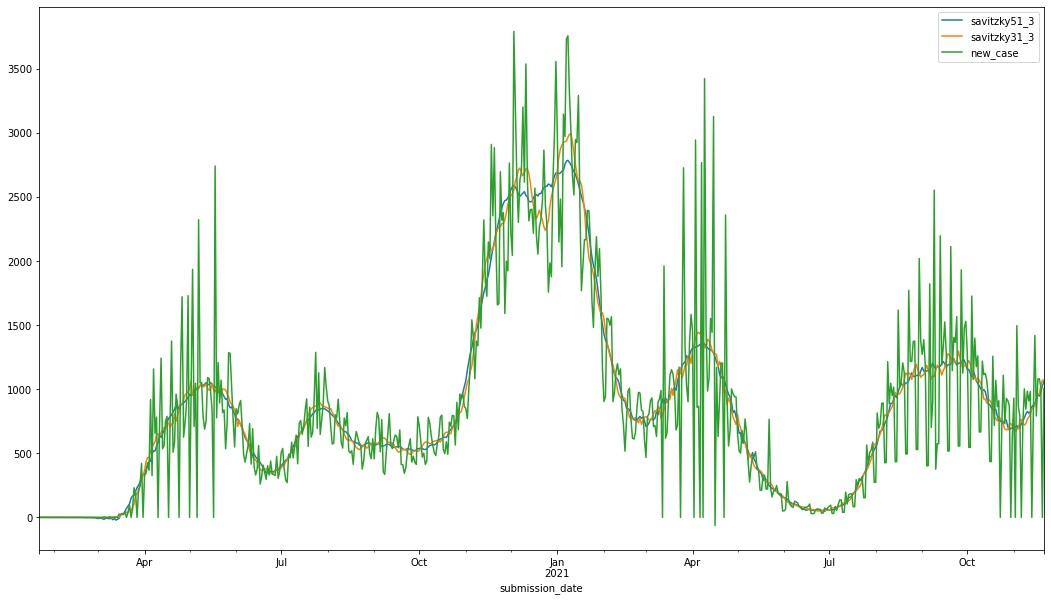

In [8]:
import numpy as np
import matplotlib.pyplot as plt

y = target_df['new_case'].to_numpy()


target_df['savitzky51_3'] =  pd.Series(savitzky_golay(y, 51, 3), index=target_df.index)
target_df['savitzky31_3'] =  pd.Series(savitzky_golay(y, 31, 3), index=target_df.index)

target_df.plot(y=['savitzky51_3','savitzky31_3','new_case'],x='submission_date')

# Conclusion and Creating the final dataset

After looking at all the results the following interpolations of the data seemed useful :
- savitzky31_3
- gauss8 
- MA7


In [9]:
case_df = pd.read_csv('../dataset/case_1121_cdc.csv',parse_dates=['submission_date'])

In [10]:
states = case_df['state'].unique()
print(f'Number of States in the CDC Case Dataset = {len(states)}')

Number of States in the CDC Case Dataset = 60


In [11]:
# FRAME_ARRAY holds the individual frames 
FRAME_ARRAY = []

for target_state in states: 
    target_df = case_df[case_df['state']==target_state]
    
    # Ordering the data according to the date
    target_df = target_df.sort_values(by=['submission_date'])

    # Creating a list of columns to drop 
    columns_to_drop = target_df.columns.to_list()

    # Removing important columns from drop list
    columns_to_drop.remove('state')
    columns_to_drop.remove('new_case')
    columns_to_drop.remove('submission_date')

    # Dropping columns not rquired 
    target_df = target_df.drop(columns_to_drop, axis=1)
    
    # Adding the desired interpolations to the table 
    target_df['caseInterpolate_MA7'] = target_df.loc[:,'new_case'].rolling(window=7).mean()
    target_df['caseInterpolate_savitzky31_3'] =  pd.Series(savitzky_golay(y, 51, 3), index=target_df.index)
    target_df['caseInterpolate_gauss8'] = pd.Series(gaussian_filter1d(target_df['new_case'].to_numpy(),8), index=target_df.index)
    target_df['caseInterpolate_gauss3'] = pd.Series(gaussian_filter1d(target_df['new_case'].to_numpy(),3), index=target_df.index)
    

    
    
    # Adding the completed dataset for the state to the full thing 
    FRAME_ARRAY.append(target_df)


    
    

/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_78601/2356744393.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window_size = np.abs(np.int(window_size))
/var/folders/66/w1588p9n1654b1yky4q5nz580000gn/T/ipykernel_78601/2356744393.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your

In [12]:
# Creating the completed Array
FINAL_RESULT_DATASET = pd.concat(FRAME_ARRAY)

# Some Interesting result visualisations 

State Picked = ['VI']


<AxesSubplot:xlabel='submission_date'>

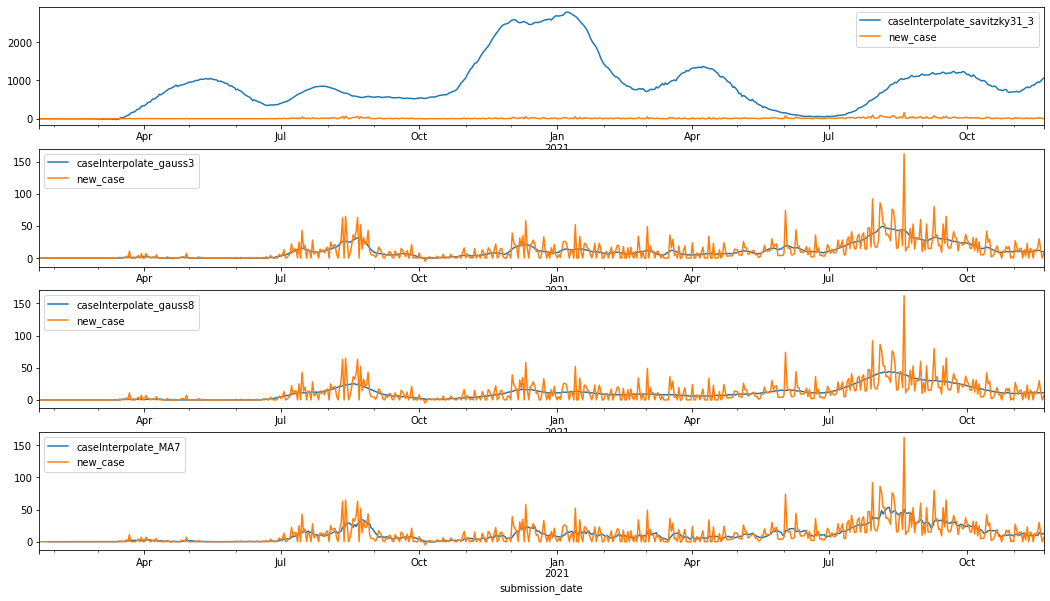

In [17]:
# Run this and it randomly generates a new state

STATE_PICK = randrange(len(states))

print(f"State Picked = {FRAME_ARRAY[STATE_PICK]['state'].unique()}")

fig, axes = plt.subplots(nrows=4, ncols=1)


FRAME_ARRAY[STATE_PICK].plot(y=['caseInterpolate_savitzky31_3','new_case'],x='submission_date',ax=axes[0])
FRAME_ARRAY[STATE_PICK].plot(y=['caseInterpolate_gauss3','new_case'],x='submission_date',ax=axes[1])
FRAME_ARRAY[STATE_PICK].plot(y=['caseInterpolate_gauss8','new_case'],x='submission_date',ax=axes[2])
FRAME_ARRAY[STATE_PICK].plot(y=['caseInterpolate_MA7','new_case'],x='submission_date',ax=axes[3])




# Saving the processed dataset to drive 

In [14]:
FINAL_RESULT_DATASET.to_csv('../outputs/case_processed.csv')

In [15]:
FINAL_RESULT_DATASET

,submission_date,state,new_case,caseInterpolate_MA7,caseInterpolate_savitzky31_3,caseInterpolate_gauss8,caseInterpolate_gauss3
3245,2020-01-22,UT,0,NaN,0.000000,0,0
2961,2020-01-23,UT,0,NaN,0.000000,0,0
5068,2020-01-24,UT,0,NaN,0.000000,0,0
518,2020-01-25,UT,0,NaN,0.000000,0,0
4498,2020-01-26,UT,0,NaN,0.000000,0,0
...,...,...,...,...,...,...,...
29049,2021-11-17,OR,976,781.428571,959.818863,770,781
16726,2021-11-18,OR,1148,945.428571,946.806972,761,721
30899,2021-11-19,OR,1072,841.142857,979.928470,754,646
19379,2021-11-20,OR,0,841.142857,1025.528211,750,577



#### BIBLIOGRAPHY 
##### __[01]__ [Article on data smoothing](https://towardsdatascience.com/five-wrong-ways-to-do-covid-19-data-smoothing-1538db6ff182)
>Smoothing periods shorter than 7 days or longer than 7 days risk disproportionately weighting the days on which results are under-reported or over-reported

##### __[02]__ [This paper on best methods of interpolation](https://arxiv.org/pdf/2104.12556.pdf)
> This paper provided us with many methods for interpolation of data because the raw covid data is practivally unusable. 

__Excerpt from the paper__
>  In addition, temporal
    interpolation methods such as best fit cubic, exponential decay and Lagrange interpolation,
    spatial interpolation methods such as inverse distance weighting, smoothing methods such
    as moving average, and spatio-temporal interpolation are applicable to fit and forecast
    COVID-19 case time series.
    
#####  __[03]__ __Savitzkey Golay Filtering__ 
> ```python
Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    ```